<a href="https://colab.research.google.com/github/EliseuODaniel/Analise-de-Sentimentos/blob/main/projeto_analise_sentimentos_reviews_de_filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise de sentimentos com Pytorch e Transformers

Arquitetura:

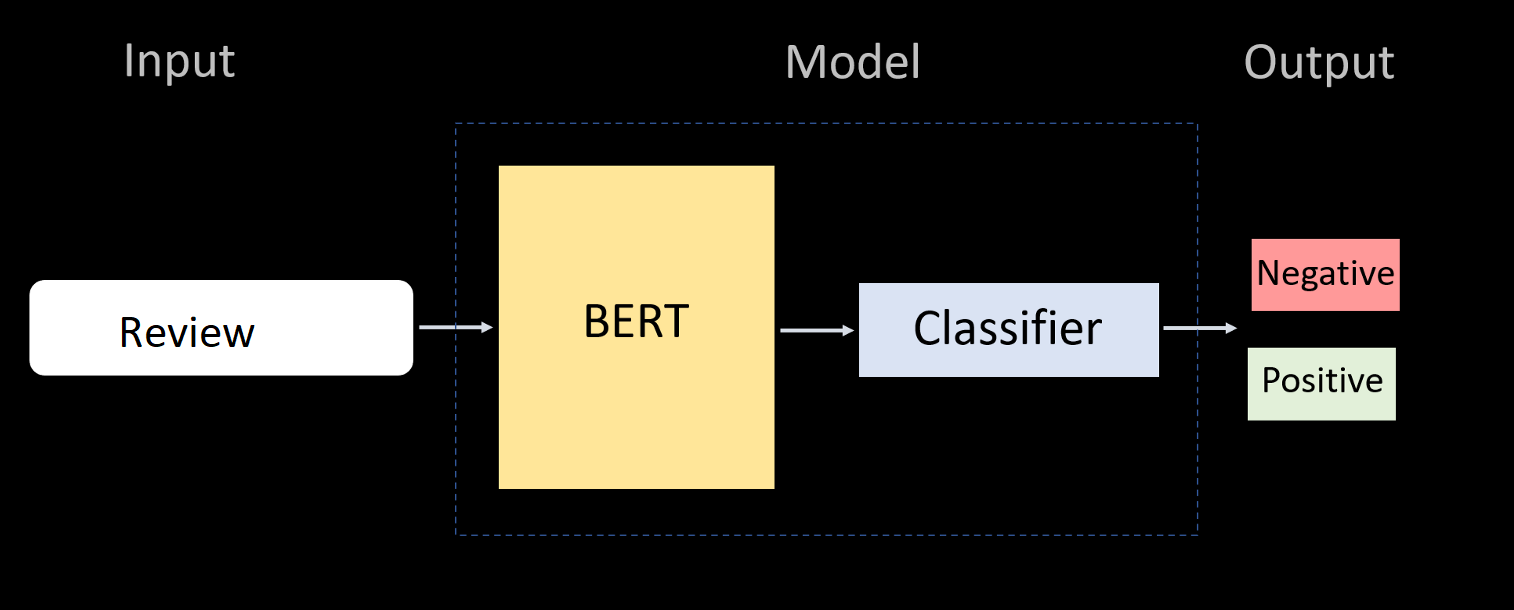

In [1]:
# transformers > modelos do site do hugging face
# datasets > biblioteca que disponibiliza os datasets do hugging face
!pip install transformers datasets 1> null


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import transformers
import datasets
import torch

In [3]:
# seleciona a gpu pra ser usada ao invés da cpu

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando: {device}")

Usando: cuda


## Carregando Dataset

Carrega dataset com dados de reviews de filmes e labels já prontas. Já dividido em dados de treino, validação e teste

In [5]:
dataset = datasets.load_dataset("sst2")

Using custom data configuration default


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
#vendo conteúdo do dataset
dataset['train']['sentence'][1]


'contains no wit , only labored gags '

In [7]:
dataset['train']['label'][1]

0

### separando dados entre treino, validação e teste

In [8]:
#limita a quantidade de frases pra 64
filter_size = 64

#dados fornecidos no formato lista de sentenças e labels

X_train_original, y_train = dataset['train']['sentence'][:filter_size],      dataset['train']['label'][:filter_size]
X_val_original, y_val     = dataset['validation']['sentence'][:filter_size], dataset['validation']['label'][:filter_size]
X_test_original, y_test   = dataset['test']['sentence'][:filter_size],       dataset['test']['label'][:filter_size]

## Carregando Modelo Pretreinado e Tokenizador

In [9]:
#carrega o modelo pré treinado distilbert (bert de tamanho reduzido)
pretrained_model = transformers.AutoModel.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
#carrega o tokenizer, que transforma as palavras em vetores
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [10]:
#exemplo do tokenizer em funcionamento
#inputs = tokenizer(X_train_original, padding = 'max_length', truncation = True, return_tensors='pt')
#inputs
#with torch.no_grad()
#    pretrained.eval()
#    output = pretrained_model(inputs['input_ids'], inputs['attention_mask'])
#resultado (passa informações no modelo e ele gera uma lista contendo as saídas numal ista de tensores)
#pra analisar os sentimentos, basta adicionar camadas densas que aprendam a classificar em positivo e negativo 
#o resultado do modelo pre treinado

#formato da saída:
#output


#tamanho da saída:
#    64: tamanho de frases de entrada
#    512: tamanho maximo da sequencia que o tokenizador fez
#    768: quantidade de neuronios da última camada do modelo pré treinado

#output[0].shape

## Freezando Pesos de Modelo Pretreinado

In [11]:
for param in pretrained_model.parameters():
    param.requires_grad = False

## Preparando Tokenização do Dataset

In [12]:
#converte as palavras das sentenças em tokens e armazena em tensores
#a saída é um tensor com duas partes:
#input_ids: cada palavra é transformada em tokens na forma de tensores 
#attention_mask: vetor pra cada uma das sentenças informando quais tokens deve ser dado atenção pelo modelo


X_train = tokenizer(X_train_original,
                    #transforma todas as frases num tamanho padrão, equivalente ao da maior frase e preenche com zeros os valores restantes
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt').to(device)
X_val = tokenizer(X_val_original,
                  padding='max_length',
                  truncation=True,
                  return_tensors='pt').to(device)
X_test = tokenizer(X_test_original,
                  padding='max_length',
                  truncation=True,
                  return_tensors='pt').to(device)



In [13]:
type(y_train)

list

In [14]:
#converte as labels do dataset em tensores

#Tensor() transforma os vetores no formato lista comum em tensor do pytorch
#view(-1,1) transforma cada número dentro do tensor como sendo um tensor independente
#to(device) envia os dados pra gpu

y_train = torch.Tensor(y_train).view(-1, 1).to(device)
y_val = torch.Tensor(y_val).view(-1, 1).to(device)
y_test = torch.Tensor(y_test).view(-1, 1).to(device)

## Definindo Modelo

In [15]:
class SentimentModel(torch.nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        #parâmetros do modelo:

        #modelo pré treinado é passado como parametro
        self.pretrained_model = pretrained_model
        #duas camadas densas do tipo linear
        #a primeira com entrada de 512*768 neuronios (é a saída do modelo pré treinado) e saída de 1000 neuronios
        self.dense1           = torch.nn.Linear(in_features=512 * 768, out_features=1000)
        #saída é 1 pois a classificação será entre positivo e negativo
        self.dense2           = torch.nn.Linear(in_features=1000, out_features=1)
        #elimina neuronios aleatóriamente, ajuda a evitar overfitting 
        self.dropout          = torch.nn.Dropout(0.2)
        #funcão não linear relu
        self.relu             = torch.nn.ReLU()
        #função não linear sigmoide
        self.sigmoid          = torch.nn.Sigmoid()

    #método que define a ordem que os dados serão passados pelo modelo
    def forward(self, X):
        #modelo pré treinado recebe como entrada os tensores gerados pelo tokenizador
        y_hat = self.pretrained_model(X['input_ids'], X['attention_mask'])
        #transforma y_hat numa camada só
        y_hat = y_hat[0].flatten(start_dim=1)
        #camada densa
        y_hat = self.dense1(y_hat)
        y_hat = self.relu(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.dense2(y_hat)
        y_hat = self.sigmoid(y_hat)
        return y_hat

## Instanciar e Treinar o Modelo

In [16]:
#instancia o modelo
sm = SentimentModel(pretrained_model).to(device)
#entra no modo de treino
##sm.train()


epochs = 40

#define a função de perda como sendo a classificação binária
criterion = torch.nn.BCELoss()
#define como otimizador o SGD
optimizer = torch.optim.SGD(sm.parameters(), lr=0.0001)

for epoch in range(epochs):
    #seleciona o modo de treino
    sm.train()
    #zera os gradientes calculados até o momento
    optimizer.zero_grad()
    #executa o forward propagation
    output = sm.forward(X_train)
    #calcula a perda (como comparação entre output e y_train)
    loss_train = criterion(output, y_train)
    #calcula os gradientes - que serão utilizados pra reduzir a perda
    loss_train.backward()
    #aplica os gradientes (mudandos os pesos) pra mudar a loss
    optimizer.step()

   #desativa o cálculo de gradientes pra nao treinar o modelo e fazer a validação dele
    with torch.no_grad():
        #usa os dados de validação pra avaliar como o modelo está se comportando
        sm.eval()
        output_val = sm.forward(X_val)
        loss_val = criterion(output_val, y_val)


    #printa o resultado do dados no treino e validação
    print(f"Epoch: {epoch}, Loss: {round(loss_train.item(), 4)}, Val. Loss: {round(loss_val.item(), 4)}")

Epoch: 0, Loss: 0.7284, Val. Loss: 0.5796
Epoch: 1, Loss: 0.5579, Val. Loss: 0.477
Epoch: 2, Loss: 0.4469, Val. Loss: 0.4069
Epoch: 3, Loss: 0.3584, Val. Loss: 0.3575
Epoch: 4, Loss: 0.305, Val. Loss: 0.3202
Epoch: 5, Loss: 0.2744, Val. Loss: 0.2915
Epoch: 6, Loss: 0.2327, Val. Loss: 0.2691
Epoch: 7, Loss: 0.2086, Val. Loss: 0.2514
Epoch: 8, Loss: 0.1943, Val. Loss: 0.2361
Epoch: 9, Loss: 0.1827, Val. Loss: 0.2232
Epoch: 10, Loss: 0.1672, Val. Loss: 0.2123
Epoch: 11, Loss: 0.1476, Val. Loss: 0.203
Epoch: 12, Loss: 0.144, Val. Loss: 0.1947
Epoch: 13, Loss: 0.1343, Val. Loss: 0.1873
Epoch: 14, Loss: 0.1291, Val. Loss: 0.1809
Epoch: 15, Loss: 0.1216, Val. Loss: 0.1751
Epoch: 16, Loss: 0.1178, Val. Loss: 0.1698
Epoch: 17, Loss: 0.1057, Val. Loss: 0.1651
Epoch: 18, Loss: 0.1126, Val. Loss: 0.1608
Epoch: 19, Loss: 0.0993, Val. Loss: 0.1569
Epoch: 20, Loss: 0.0957, Val. Loss: 0.1532
Epoch: 21, Loss: 0.0905, Val. Loss: 0.1499
Epoch: 22, Loss: 0.093, Val. Loss: 0.1467
Epoch: 23, Loss: 0.0943, V

## Testando Modelo

In [17]:

#desabilita o cálculo de gradientes, pois será apenas utilização do modelo sem mudança dos pesos
with torch.no_grad():
    #seleciona o modo de validação
    sm.eval()
    output_test = sm.forward(X_test)
    loss_test = criterion(output_test, y_test)

#print(f"Test Loss: {round(loss_test.item(), 4)}\n")

print(f"Exemplo Negativo:\n{X_test_original[0]}\n{output_test[0]}\n")
print(f"Exemplo Negativo:\n{X_test_original[1]}\n{output_test[1]}\n")
print(f"Exemplo Positivo:\n{X_test_original[2]}\n{output_test[2]}\n")
print(f"Exemplo Positivo:\n{X_test_original[3]}\n{output_test[3]}\n")
print(f"Exemplo Positivo:\n{X_test_original[4]}\n{output_test[4]}\n")

Exemplo Negativo:
uneasy mishmash of styles and genres .
tensor([0.0277], device='cuda:0')

Exemplo Negativo:
this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
tensor([0.0344], device='cuda:0')

Exemplo Positivo:
by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .
tensor([0.6877], device='cuda:0')

Exemplo Positivo:
director rob marshall went out gunning to make a great one .
tensor([0.9659], device='cuda:0')

Exemplo Positivo:
lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .
tensor([0.9441], device='cuda:0')

